Imports for the code below

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum


In [15]:
class Player(Enum):
    ONE = 1
    TWO = 2

class Board:
    def __init__(self, width: int = 7, height: int = 6) -> None:
        self.width = width
        self.height = height
        self.board = [[0] * height for _ in range(width)]
    
    def __str__(self) -> str:
        return str(self.board)
    
    def __repr__(self) -> str:
        return str(self.board)
    
    def __eq__(self, __value: object) -> bool:
        return isinstance(__value, Board) and all(map(lambda x: x[0] == x[1], zip(self.board, __value.board)))
    
    def __hash__(self) -> int:
        return hash(str(self.board))
    
    def put_dot(self, column: int, player: Player):
        if column < 0 or column >= self.width:
            raise ValueError(f"Column {column} is out of range")
        if 0 not in self.board[column]:
            raise ValueError(f"Column {column} is full: {self.board[column]}")
        index = self.board[column].index(0)
        self.board[column][index] = player.value
        
    def full(self) -> bool:
        return all(map(lambda x: 0 not in x, self.board))
    
    def render(self):
        _, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.imshow(np.ones((self.height, self.width, 3)), extent=[0, self.width, 0, self.height], zorder=0)

        for x in range(self.width):
            for y in range(self.height):
                circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color='gray', zorder=1)
                ax.add_patch(circle)

        for col_index, column in enumerate(self.board):
            for row_index, cell in enumerate(column):
                if cell != 0:
                    color = 'red' if cell == 1 else 'yellow'
                    circle = plt.Circle((col_index + 0.5, row_index + 0.5), 0.4, color=color, zorder=2)
                    ax.add_patch(circle)

        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()

#### Monte Carlo Tree Search

In [16]:
from typing import Callable, Iterable

class MCTSNode:
    def __init__(self, parent: 'MCTSNode', state: object, next_states: Callable[[object], Iterable[tuple[object, object]]]) -> None:
        self.parent = parent
        self.children: dict[object, object] = {}
        self.state = state
        self.next_states = next_states
        
        self.visits = 1
        self.value = 0
        
    def __str__(self) -> str:
        return f"Node({str(self.state)}, {self.visits}, {self.value})"
    
    def __repr__(self) -> str:
        return f"Node({str(self.state)}, {self.visits}, {self.value})"
    
    def __eq__(self, __value: object) -> bool:
        return isinstance(__value, MCTSNode) and self.state == __value.state
    
    def __hash__(self) -> int:
        return hash(self.state)
    
    def is_leaf(self) -> bool:
        next_states_count = len(self.next_states(self.state))
        if next_states_count == 0:
            return True
        return len(self.children) != next_states_count
    
    def exploration_score(self, c: float) -> float:
        return c * np.sqrt(np.log(self.parent.visits) / self.visits)
    
    def exploatation_score(self) -> float:
        return self.value / self.visits
    
    def score(self, c: float) -> float:
        return self.exploatation_score() + self.exploration_score(c)

In [17]:
import random

def best_child(node: MCTSNode, c: float) -> MCTSNode:
    if not node.children:
        return None
    return max(node.children.items(), key=lambda n: n[1].score(c))

def expand(node: MCTSNode) -> MCTSNode:
    available = [s for s in node.next_states(node.state) if s[1] not in node.children]
    if available:
        next_state, action = random.choice(available)
        child = MCTSNode(node, next_state, node.next_states)
        node.children[action] = child
        return child
    return node

def tree_policy(node: MCTSNode, c: float) -> MCTSNode:
    while not node.is_leaf():
        node = best_child(node, c)[1]
    return expand(node)

def rollout(node: MCTSNode, reward: Callable[[object], float], max_rollout: int) -> float:
    state = node.state
    reward_value = float(reward(state))
    for _ in range(max_rollout):
        reward_value = max(reward_value, reward(state))
        next_states = list(node.next_states(state))
        if next_states:
            state = random.choice(next_states)[0]
        else:
            break
    return reward_value

def backup(node: MCTSNode, value: float) -> None:
    while node is not None:
        node.visits += 1
        node.value += value
        node = node.parent

def create_mcts(root_state: object, next_states: Callable[[object], Iterable[tuple[object, object]]],
                reward: Callable[[object], float], c: float = 0.5, budget: int = 1000, max_rollout: int = 100) -> MCTSNode:
    root = MCTSNode(None, root_state, next_states)
    while budget > 0:
        node = tree_policy(root, c)
        value = rollout(node, reward, max_rollout)
        backup(node, value)
        budget -= 1
        
    return root

In [18]:
from copy import deepcopy

def next_states(state: Board) -> list[tuple[Board, int]]:
    next_states = []
    for column in range(state.width):
        if 0 in state.board[column]:
            new_state = Board(state.width, state.height)
            new_state.board = deepcopy(state.board)
            new_state.put_dot(column, Player.TWO)
            next_states.append((new_state, column))
    return next_states

def check_winner(state: Board, player: Player) -> bool:
    for row in range(state.height):
        for col in range(state.width - 3):
            if state.board[col][row] == player.value and state.board[col+1][row] == player.value and state.board[col+2][row] == player.value and state.board[col+3][row] == player.value:
                return True
    
    for col in range(state.width):
        for row in range(state.height - 3):
            if state.board[col][row] == player.value and state.board[col][row+1] == player.value and state.board[col][row+2] == player.value and state.board[col][row+3] == player.value:
                return True
    
    for row in range(state.height - 3):
        for col in range(state.width - 3):
            if state.board[col][row] == player.value and state.board[col+1][row+1] == player.value and state.board[col+2][row+2] == player.value and state.board[col+3][row+3] == player.value:
                return True
    
    for row in range(state.height - 3):
        for col in range(3, state.width):
            if state.board[col][row] == player.value and state.board[col-1][row+1] == player.value and state.board[col-2][row+2] == player.value and state.board[col-3][row+3] == player.value:
                return True
    
    return False

def reward(self) -> float:
    CENTER_COLUMN_MULTIPLIER = 3
    TWO_IN_ROW_SCORE = 10
    THREE_IN_ROW_SCORE = 100
    FOUR_IN_ROW_SCORE = 1000  # Winning condition

    score = 0
    
    def count_sequences(num_in_row: int, player: int):
        count = 0
        # Horizontal
        for y in range(self.height):
            for x in range(self.width - num_in_row + 1):
                if all(self.board[x + i][y] == player for i in range(num_in_row)):
                    count += 1

        # Vertical
        for x in range(self.width):
            for y in range(self.height - num_in_row + 1):
                if all(self.board[x][y + i] == player for i in range(num_in_row)):
                    count += 1

        # Diagonal (positive slope)
        for x in range(self.width - num_in_row + 1):
            for y in range(self.height - num_in_row + 1):
                if all(self.board[x + i][y + i] == player for i in range(num_in_row)):
                    count += 1

        # Diagonal (negative slope)
        for x in range(self.width - num_in_row + 1):
            for y in range(num_in_row - 1, self.height):
                if all(self.board[x + i][y - i] == player for i in range(num_in_row)):
                    count += 1

        return count

    center_column = [self.board[self.width // 2][i] for i in range(self.height)]
    score += center_column.count(1) * CENTER_COLUMN_MULTIPLIER

    score += count_sequences(2, 1) * TWO_IN_ROW_SCORE
    score += count_sequences(3, 1) * THREE_IN_ROW_SCORE
    score += count_sequences(4, 1) * FOUR_IN_ROW_SCORE

    score -= count_sequences(2, 2) * TWO_IN_ROW_SCORE / 2
    score -= count_sequences(3, 2) * THREE_IN_ROW_SCORE / 2
    score -= count_sequences(4, 2) * FOUR_IN_ROW_SCORE / 2

    return float(score)

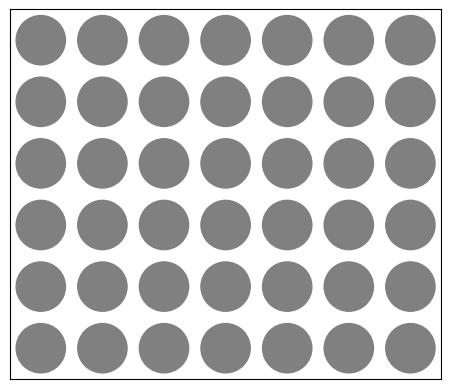

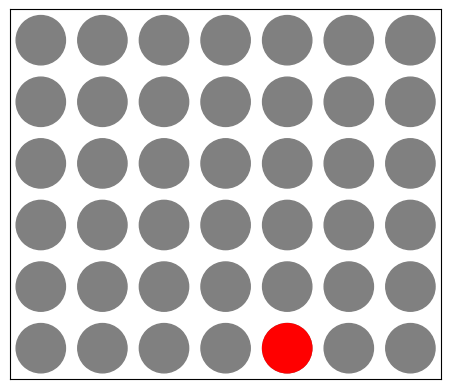

Computer is thinking...


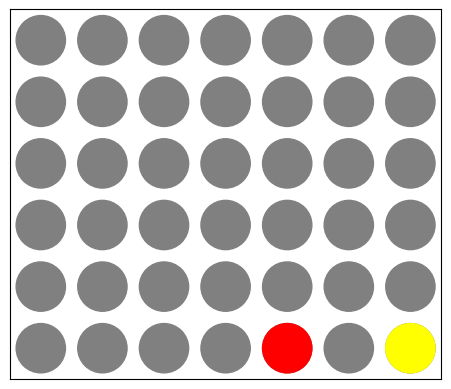

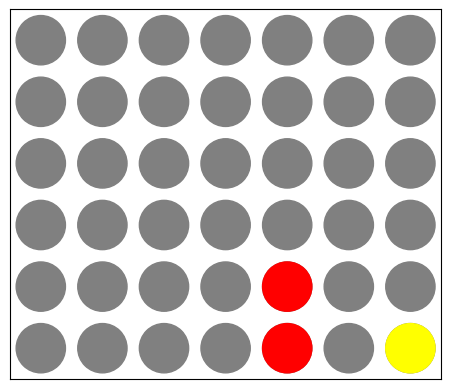

Computer is thinking...


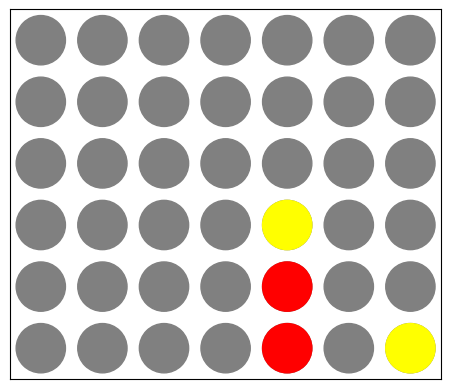

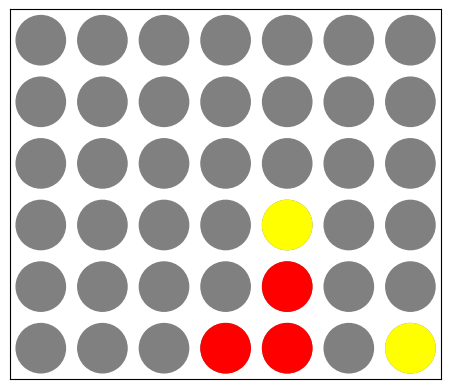

Computer is thinking...


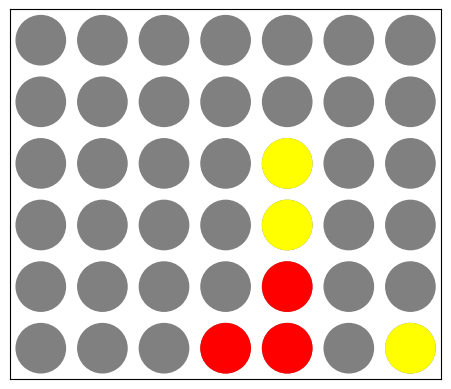

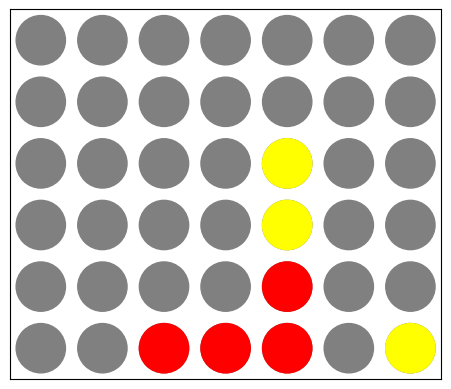

Computer is thinking...


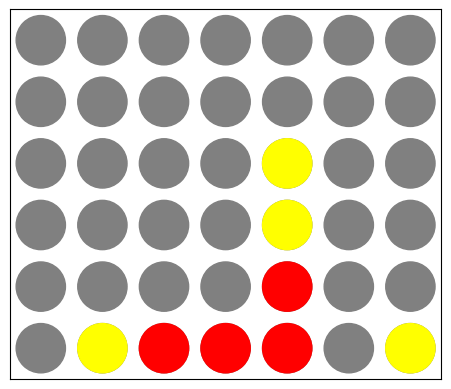

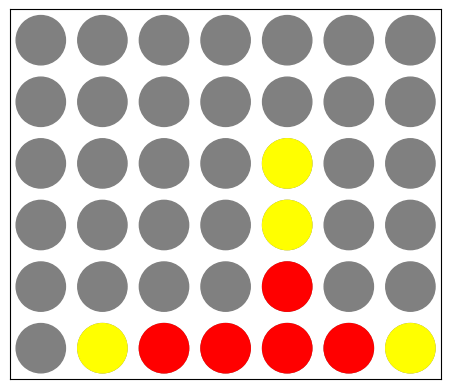

You won!


In [20]:
board = Board()
board.render()

root: MCTSNode = None
while not board.full():
    human_move = int(input("Enter column: "))
    board.put_dot(human_move, Player.ONE)
    board.render()
    
    if check_winner(board, Player.ONE):
        print("You won!")
        break
    
    print("Computer is thinking...")
    if root is None:
        root = create_mcts(board, next_states, reward, 0.1, 1000, 50)
    else:
        if human_move in root.children:
            root = root.children.get(human_move, None)
        else:
            root = create_mcts(board, next_states, reward, 0.1, 1000, 50)
    
    if root is None or not root.children:
        root = create_mcts(board, next_states, reward, 0.1, 1000, 50)
            
    computer_move = best_child(root, 0.0)[0]
    root = root.children[computer_move]
    
    board.put_dot(computer_move, Player.TWO)
    board.render()
    
    if check_winner(board, Player.TWO):
        print("Computer won!")
        break